In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq

import muon as mu

import warnings
warnings.filterwarnings('ignore')

/home/dbdimitrov/.local/lib/python3.8/site-packages/pynndescent/utils.py:205: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(
/home/dbdimitrov/.local/lib/python3.8/site-packages/pynndescent/utils.py:304: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(


In [2]:
import matplotlib.pyplot as plt
import liana as li
import plotnine as p9

In [3]:
import omnipath as op
import decoupler as dc

In [4]:
slides = ["A1", "C1", "B1"]

In [5]:
## load slide
slide = "C1"
exp = "V11L12-109" # V11T17-102 V11L12-109 V11T16-085

In [6]:
from functools import reduce

In [7]:
hvg = []
mdatas = {}

for slide in slides:    
    slide_path = f"../data/sma/{exp}/{exp}_{slide}/output_data"
    mdatas[slide] = mu.read_h5mu(os.path.join(slide_path, "sma.h5mu"))
    msi = mdatas[slide].mod["msi"]
    sc.pp.highly_variable_genes(msi, flavor='cell_ranger', n_top_genes=250)
    
     # annotated which do not contain peak,
    # annotated = msi.var['annotated'].astype(str).unique()
    # annotated = [a for a in annotated if "peak" not in a]
    
    msk = (msi.var['highly_variable'].values)
    hvg.append(list(msi.var[msk].index))

In [8]:
hvg = reduce(np.intersect1d, hvg)

In [ ]:
# annotated = msi.var['annotated'].astype(str).unique()
# annotated = [a for a in annotated if ("peak" not in a) and (a in msi.var.index)]

In [9]:
tf_net = dc.get_collectri(organism="mouse")

In [10]:
# msigdb = dc.get_resource('MSigDB')
# msigdb = msigdb[(msigdb['collection'].str.contains("kegg"))]
# # remove KEGG_
# msigdb['geneset'] = msigdb['geneset'].str.replace("KEGG_", "")
# msigdb['geneset'] = msigdb['geneset'].replace("_", "").str.title()
# msigdb['genesymbol'] = msigdb['genesymbol'].str.title()
# msigdb.rename(columns={"geneset": "source", "genesymbol":"target"}, inplace=True)
# msigdb = msigdb.drop_duplicates()

In [11]:
# kegg = op.requests.Annotations.get(resources=["KEGG-PC"], entity_types=['protein'])
# kegg = kegg[["value", "genesymbol"]].rename({"value": "source", "genesymbol": "target"}, axis=1)
# kegg = kegg[["source", "target"]].drop_duplicates()
# kegg['target'] = kegg['target'].str.title()

In [12]:
# Load metabolite receptor interactions
resource =  pd.read_csv('applications/data/MR_brain_20230808.csv')
# resource = dc.translate_net(resource, columns=['receptor'])
resource['receptor'] = resource['receptor'].str.title()
resource.head()

Unnamed: 0       ligand receptor
0           1  HMDB0000112   Gabrb2
1           3  HMDB0000216   Adra2B
2           4  HMDB0000068   Adra2B
3          20  HMDB0000148     Grm8
4          49  HMDB0000112   Gabra5

In [13]:
met_net = pd.read_csv("applications/data/PD_processed.csv")
# met_net = dc.translate_net(met_net, columns=['Symbol'])
met_net['Symbol'] = met_net['Symbol'].str.title()
met_net.head()

Unnamed: 0         HMDB   Symbol  Direction                      MetName  \
0       18524  HMDB0059655    Phgdh          1           2-Hydroxyglutarate   
1       21107  HMDB0006242  Aldh3A1         -1  3,4-Dihydroxymandelaldehyde   
2       21117  HMDB0000042  Aldh3A1          1                  Acetic acid   
3       21116  HMDB0001487  Aldh3A1          1                         NADH   
4       21115  HMDB0000663  Aldh3A1          1                Glucaric acid   

  Transport T_direction Reversibility                          DB     Type  
0   unknown     unknown  irreversible  ReconProductionDegradation  met_est  
1   unknown     unknown  irreversible  ReconProductionDegradation  met_est  
2   unknown     unknown  irreversible  ReconProductionDegradation  met_est  
3   unknown     unknown  irreversible  ReconProductionDegradation  met_est  
4   unknown     unknown  irreversible  ReconProductionDegradation  met_est

In [14]:
resource['metabolite'] = resource['ligand'].map(dict(met_net[['HMDB', 'MetName']].values))

In [15]:
# mdata = mu.read_h5mu(os.path.join(slide_path, "sma.h5mu"))
# rna = mdata.mod["rna"]
# msi = mdata.mod["msi"]

In [16]:
# [resource['ligand']=='HMDB0000073']
receptors = np.unique(resource['receptor'])

In [ ]:
interaction_list = {}
target_list = {}

for slide in slides:
    mdata = mdatas[slide]
    rna = mdata.mod["rna"]
    msi = mdata.mod["msi"]
    sc.pp.scale(msi, max_value=5)
    msi = msi[:, hvg].copy()
    
    # distances of metabolties to RNA
    reference = mdata.mod["msi"].obsm["spatial"]
    li.ut.spatial_neighbors(rna, bandwidth=1000, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)
    
    # dc.run_ulm(rna, net = msigdb, use_raw=False, weight=None)
    # path = li.ut.obsm_to_adata(rna, "ulm_estimate")
    
    dc.run_ulm(rna, net = tf_net, use_raw=False, weight=None)
    tf = li.ut.obsm_to_adata(rna, "ulm_estimate")
    
    rec = rna[:, receptors[np.isin(receptors, rna.var.index)]].copy()

    # misty
    mdata.update_obs()
    misty = li.mt.MistyData({"intra": msi, "tf":tf, "receptor":rec}, enforce_obs=False, obs=mdata.obs) # , "path":path
    misty(model="linear", verbose=True, bypass_intra=True, maskby='lesion')
    
    interaction_list[slide] = misty.uns['interactions'].copy()
    target_list[slide] = misty.uns['target_metrics'].copy()

In [ ]:
interactions = pd.concat(interaction_list).reset_index()
target_metrics = pd.concat(target_list).reset_index()

In [ ]:
interactions.to_csv("interactions.csv")

In [ ]:
target_metrics.to_csv("target_metrics.csv")

In [ ]:
# fill missing values
target_metrics.fillna(0, inplace=True)

## Visualize

In [17]:
target_metrics = pd.read_csv("target_metrics.csv", index_col=None)

In [18]:
interactions = pd.read_csv("interactions.csv", index_col=None)

In [19]:
targets = target_metrics.groupby(['target', 'intra_group']).agg({"gain_R2":'mean'}).sort_values("gain_R2", ascending=False).reset_index()
top_targets = targets['target'].head(20).unique()

In [20]:
# as categorical with levels from targets
target_metrics['target'] = pd.Categorical(target_metrics['target'], categories=targets['target'].unique())

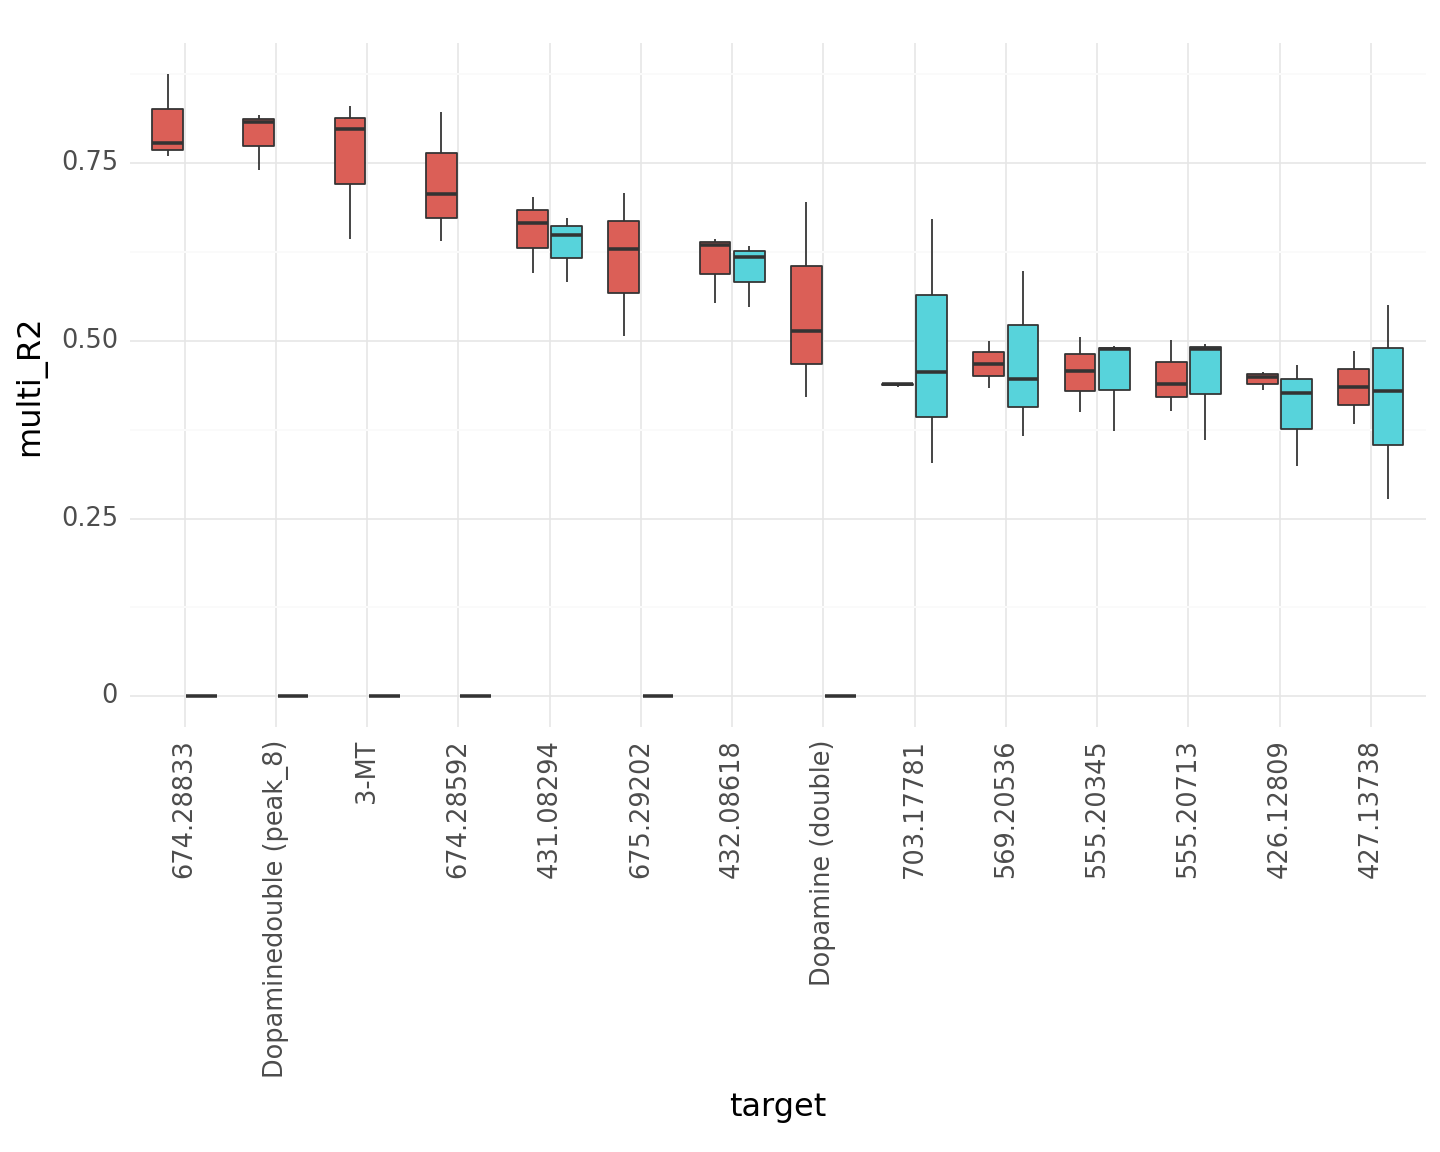

<Figure Size: (720 x 576)>

In [21]:
### boxplot 
(
    p9.ggplot(target_metrics[target_metrics['target'].isin(top_targets)], p9.aes(x='target', y='multi_R2', fill='intra_group')) +
    p9.geom_boxplot() +
    # 
    p9.theme_minimal(base_size=16) +
    # rotate
    p9.theme(axis_text_x=p9.element_text(angle=90),
             legend_position='none',
             figure_size=(10, 8))
    
)

In [ ]:
# (
#     li.pl.target_metrics(target_metrics=target_metrics, stat='multi_R2', top_n=25, filterby='intra_group', filter_lambda=lambda x: x=='lesion') +
#     # limits
#     p9.ylim(0, 1)
# )

In [22]:
group1 = interactions[(interactions['predictor']=='Drd2') & (interactions['intra_group']=='lesioned')].copy()
group2 = interactions[(interactions['predictor']=='Drd2') & (interactions['intra_group']=='intact')].copy()

In [23]:
from scipy.stats import ttest_ind

In [24]:
tt = ttest_ind(group1['importances'], group2['importances'])

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


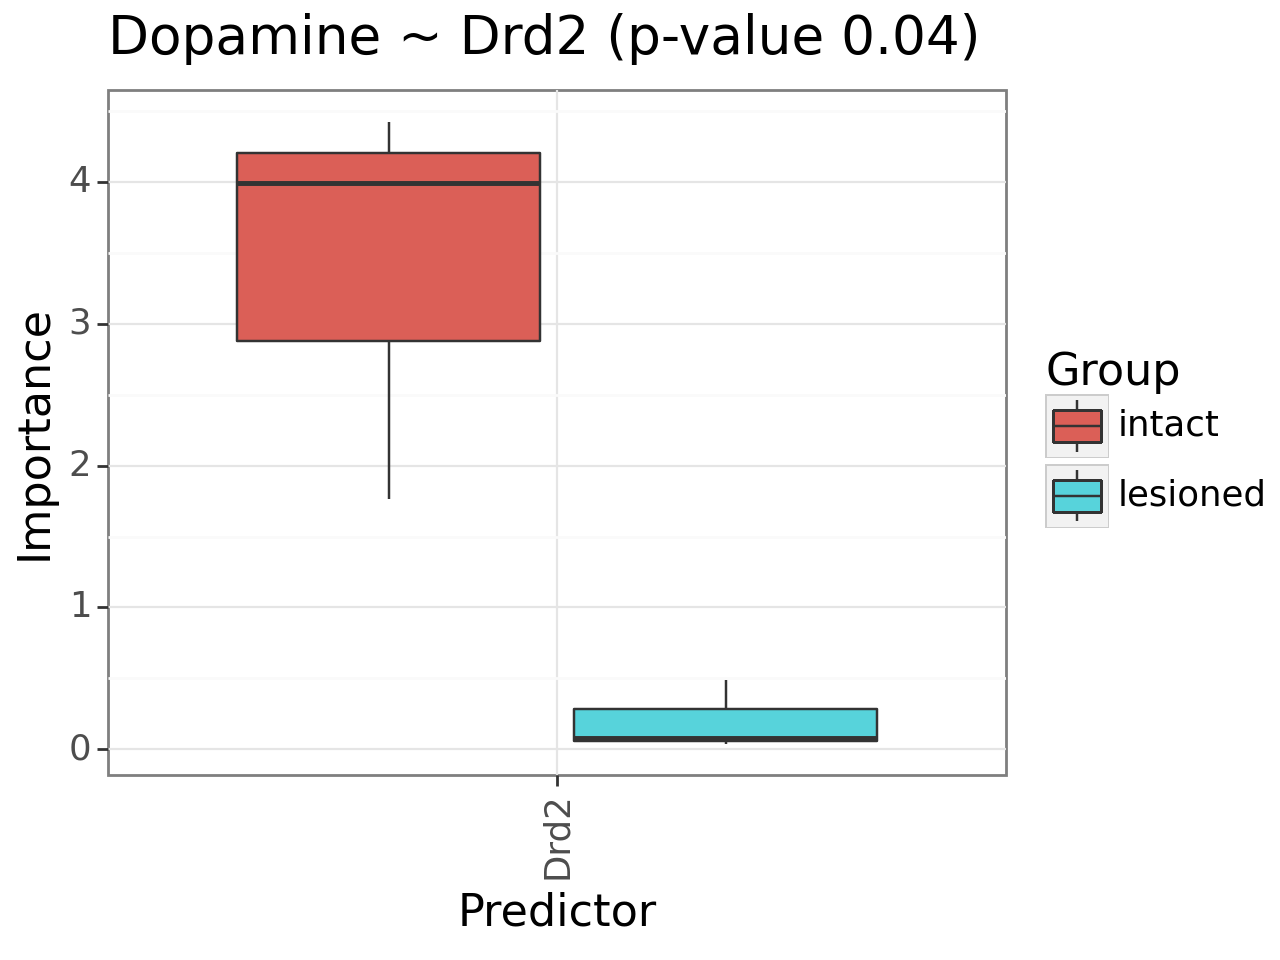

<Figure Size: (640 x 480)>

In [25]:
(
    p9.ggplot(interactions[(interactions['predictor']=='Drd2') & (interactions['target']=="Dopamine (double)")],
              p9.aes(x='predictor',
                     y='importances',
                     fill='intra_group',
                     group='intra_group')) +
    p9.geom_boxplot() +
    p9.theme_bw(base_size=16) +
    p9.theme(axis_text_x=p9.element_text(angle=90),
             legend_title=p9.element_text(text='Group')) +
    p9.labels.ggtitle(f"Dopamine ~ Drd2 (p-value {round(tt[1], 2)})") + 
    # add text for t-test result
    p9.labels.xlab("Predictor") +
    p9.labels.ylab("Importance")
)

In [26]:
## plot interactions
dop_ints = interactions[interactions['target']=='Dopamine (double)'].copy()
dop_ints = dop_ints.groupby(['target', 'intra_group', 'predictor', 'view']).agg({'importances': 'mean'}).reset_index().sort_values('importances', ascending=False, key=abs)
predictors = dop_ints['predictor'].unique()[:20]

In [27]:
dop_ints.head(30)

target intra_group predictor      view  importances
104   Dopamine (double)      intact      Drd2  receptor     3.395768
58    Dopamine (double)      intact     Chrm4  receptor     3.248798
215   Dopamine (double)      intact    Gpr143  receptor    -2.917196
671   Dopamine (double)      intact      Tfeb        tf    -2.540932
286   Dopamine (double)      intact     Hoxb9        tf    -2.532546
134   Dopamine (double)      intact     Epas1        tf     2.255116
718   Dopamine (double)      intact     Zgpat        tf     2.163009
564   Dopamine (double)      intact      Rorc        tf     2.092641
223   Dopamine (double)      intact     Gria4  receptor    -2.032541
781   Dopamine (double)    lesioned      Cdx1        tf    -2.012821
520   Dopamine (double)      intact     Ppara  receptor    -2.006187
220   Dopamine (double)      intact     Gria1  receptor    -1.985390
543   Dopamine (double)      intact      Rarb  receptor     1.938246
279   Dopamine (double)      intact     Hoxa9        tf    -1.879538
530   Dopamine (double)      intact     Prop1        tf     1.868140
256   Dopamine (double)      intact      Hey2        tf    -1.848965
214   Dopamine (double)      intact     Gper1  receptor     1.835769
588   Dopamine (double)      intact      Six3        tf     1.788797
68    Dopamine (double)      intact    Chrnb3  receptor     1.719276
45    Dopamine (double)      intact  Catsper3  receptor    -1.648475
538   Dopamine (double)      intact    Ptger4  receptor     1.637194
939   Dopamine (double)    lesioned      Gcm1        tf     1.635048
696   Dopamine (double)      intact      Xbp1        tf    -1.618401
734   Dopamine (double)      intact   Znf804a        tf    -1.618060
702   Dopamine (double)      intact    Zbtb16        tf     1.608402
810   Dopamine (double)    lesioned     Creb5        tf    -1.595721
571   Dopamine (double)      intact      Rxrb  receptor    -1.568365
573   Dopamine (double)      intact      Rxrg  receptor     1.547530
1269  Dopamine (double)    lesioned     Ptgdr  receptor     1.532379
505   Dopamine (double)      intact     Pitx2        tf     1.530212

In [28]:
from scipy.stats import ttest_ind

In [29]:
targets = ['Dopamine (double)']

# Create a dictionary to store the t-test results
t_test_results = pd.DataFrame({'target':[], 'predictor':[], 't_statistic': [], 'p_value': [], 'view':[]})

# Perform t-test for all combinations of groups
for target in targets:
    for predictor in interactions['predictor'].unique():
        
        msk = (interactions['target'] == target) & (interactions['predictor'] == predictor)
        df = interactions[msk]
    
        # Extract data for the two groups
        data_group1 = df[df['intra_group'] == 'lesioned']['importances']
        data_group2 = df[df['intra_group'] == 'intact']['importances']
        view = df['view'].unique()[0]

        # Perform t-test
        t_stat, p_value = ttest_ind(data_group1, data_group2)

        # Store results in the dictionary
        # key interates the row
        key = f"{target}_{predictor}"
        t_test_results.loc[key, 't_statistic'] = t_stat
        t_test_results.loc[key, 'p_value'] = p_value
        t_test_results.loc[key, 'target'] = target
        t_test_results.loc[key, 'predictor'] = predictor
        t_test_results.loc[key, 'view'] = view

In [30]:
t_test_results.dropna().sort_values("p_value").head(50)

target predictor  t_statistic   p_value  \
Dopamine (double)_Preb     Dopamine (double)      Preb    -6.767154  0.002488   
Dopamine (double)_Pin1     Dopamine (double)      Pin1     6.032084  0.003807   
Dopamine (double)_Chrnb3   Dopamine (double)    Chrnb3    -5.784839  0.004437   
Dopamine (double)_Hey2     Dopamine (double)      Hey2     5.028942  0.007339   
Dopamine (double)_Nr1i2    Dopamine (double)     Nr1i2     4.456493  0.011191   
Dopamine (double)_Srsf2    Dopamine (double)     Srsf2     4.314101  0.012505   
Dopamine (double)_Mycn     Dopamine (double)      Mycn    -4.151146  0.014247   
Dopamine (double)_Six3     Dopamine (double)      Six3    -4.081917  0.015075   
Dopamine (double)_Tfap2c   Dopamine (double)    Tfap2c     4.080916  0.015087   
Dopamine (double)_Drd2     Dopamine (double)      Drd2    -3.822457  0.018739   
Dopamine (double)_Glis3    Dopamine (double)     Glis3     3.770923  0.019589   
Dopamine (double)_Glra3    Dopamine (double)     Glra3    -3.706895  0.020710   
Dopamine (double)_Grm2     Dopamine (double)      Grm2    -3.669423  0.021402   
Dopamine (double)_E2f2     Dopamine (double)      E2f2    -3.643130  0.021904   
Dopamine (double)_Ppard    Dopamine (double)     Ppard     3.636408  0.022035   
Dopamine (double)_Chrnb4   Dopamine (double)    Chrnb4     6.600224  0.022194   
Dopamine (double)_Grm3     Dopamine (double)      Grm3    -3.601450  0.022729   
Dopamine (double)_Wwtr1    Dopamine (double)     Wwtr1     3.558534  0.023617   
Dopamine (double)_Sirt1    Dopamine (double)     Sirt1     3.549931  0.023800   
Dopamine (double)_Pou4f2   Dopamine (double)    Pou4f2    -3.464645  0.025709   
Dopamine (double)_Pax8     Dopamine (double)      Pax8     3.455156  0.025932   
Dopamine (double)_Hes6     Dopamine (double)      Hes6    -3.353231  0.028483   
Dopamine (double)_Hoxa9    Dopamine (double)     Hoxa9     3.282929  0.030417   
Dopamine (double)_Epas1    Dopamine (double)     Epas1    -3.282136  0.030440   
Dopamine (double)_Nr6a1    Dopamine (double)     Nr6a1    -3.270925  0.030762   
Dopamine (double)_Grhl3    Dopamine (double)     Grhl3    -3.253512  0.031272   
Dopamine (double)_Sox5     Dopamine (double)      Sox5    -3.219739  0.032289   
Dopamine (double)_Foxn4    Dopamine (double)     Foxn4    -3.200910  0.032872   
Dopamine (double)_Gli3     Dopamine (double)      Gli3    -3.191978  0.033154   
Dopamine (double)_Gli2     Dopamine (double)      Gli2     3.173380  0.033748   
Dopamine (double)_Pparg    Dopamine (double)     Pparg    -3.135006  0.035016   
Dopamine (double)_Hif1a    Dopamine (double)     Hif1a     3.123845  0.035395   
Dopamine (double)_Fezf1    Dopamine (double)     Fezf1     3.059815  0.037665   
Dopamine (double)_Mbd1     Dopamine (double)      Mbd1    -3.045576  0.038193   
Dopamine (double)_Zfpm2    Dopamine (double)     Zfpm2     3.000849  0.039909   
Dopamine (double)_Phf20    Dopamine (double)     Phf20     2.964805  0.041357   
Dopamine (double)_Klf11    Dopamine (double)     Klf11    -2.962437  0.041454   
Dopamine (double)_Tbx21    Dopamine (double)     Tbx21     2.926173  0.042978   
Dopamine (double)_Sp3      Dopamine (double)       Sp3     2.868533  0.045536   
Dopamine (double)_Tbr1     Dopamine (double)      Tbr1    -2.856839  0.046076   
Dopamine (double)_Irf6     Dopamine (double)      Irf6    -2.850793  0.046359   
Dopamine (double)_Ebf1     Dopamine (double)      Ebf1    -2.824299  0.047620   
Dopamine (double)_Creb3l1  Dopamine (double)   Creb3l1    -2.807329  0.048448   
Dopamine (double)_Rorc     Dopamine (double)      Rorc    -2.244864  0.048601   
Dopamine (double)_Rfx1     Dopamine (double)      Rfx1    -2.802157  0.048704   
Dopamine (double)_Tlx1     Dopamine (double)      Tlx1    -2.782490  0.049692   
Dopamine (double)_Spib     Dopamine (double)      Spib     2.779060  0.049866   
Dopamine (double)_Tgif1    Dopamine (double)     Tgif1     2.778882  0.049875   
Dopamine (double)_Elf2     Dopamine (double)      Elf2    -2.772170  

In [31]:
predictor = t_test_results.dropna().sort_values("p_value").head(50)[t_test_results['view']=='tf']['predictor'].values

In [32]:
predictor = li.pl.interactions(interactions=dop_ints, top_n=20, filterby='intra_group', filter_lambda=lambda x: x=='intact', view='tf').data['predictor']

In [33]:
interactions[interactions['predictor']=="Nab2"].sort_values(["predictor", "intra_group", "importances"])

Unnamed: 0 level_0  level_1     target predictor intra_group view  \
191107      191107      B1    77225  699.22822      Nab2      intact   tf   
319598      319598      C1    83870  757.32781      Nab2      intact   tf   
157775      157775      B1    40201   429.0767      Nab2      intact   tf   
164185      164185      B1    47321  431.08294      Nab2      intact   tf   
306918      306918      C1    69710  674.28592      Nab2      intact   tf   
...            ...     ...      ...        ...       ...         ...  ...   
89296        89296      A1    99448  901.36356      Nab2    lesioned   tf   
67842        67842      A1    75546  694.24719      Nab2    lesioned   tf   
223798      223798      B1   113537  985.33781      Nab2    lesioned   tf   
43864        43864      A1    48832  431.16838      Nab2    lesioned   tf   
159698      159698      B1    42337  429.14134      Nab2    lesioned   tf   

        importances  
191107    -3.177359  
319598    -3.042071  
157775    -2.653715  
164185    -2.515587  
306918    -2.313481  
...             ...  
89296      2.236098  
67842      2.346963  
223798     2.616625  
43864      2.940343  
159698     3.457110  

[510 rows x 8 columns]

In [34]:
tfs = {}

for slide in slides:
    dc.run_ulm(mdatas[slide].mod['rna'], net = tf_net, use_raw=False, weight=None)
    tf = li.ut.obsm_to_adata(mdatas[slide].mod['rna'], "ulm_estimate")
    tf.obs['slide'] = slide
    tf = tf[tf.obs['region']=='striatum']
    tfs[slide] = tf

In [35]:
ptf = dc.get_pseudobulk(sc.concat(tfs), sample_col='slide', groups_col='lesion', skip_checks=True, min_cells=0, min_counts=0, mode='mean')

In [36]:
# order acc to var
ptf.var['var'] = ptf.X.var(axis=0) / ptf.X.mean(axis=0)

In [37]:
t_test_results = pd.DataFrame({'tf':[], 't_statistic': [], 'p_value': []})

for target in ptf.var.index:
    data1 = ptf[ptf.obs['lesion']=='intact', ptf.var.index==target].X.flatten()
    data2 = ptf[ptf.obs['lesion']=='lesioned', ptf.var.index==target].X.flatten()
    
    t_stat, p_value =  ttest_ind(data1, data2)
    t_test_results.loc[target, 't_statistic'] = t_stat
    t_test_results.loc[target, 'p_value'] = p_value
    t_test_results.loc[target, 'tf'] = target
    
    

In [38]:
t_test_results[t_test_results['tf']=='Nab2']

tf  t_statistic   p_value
Nab2  Nab2     3.026768  0.038904

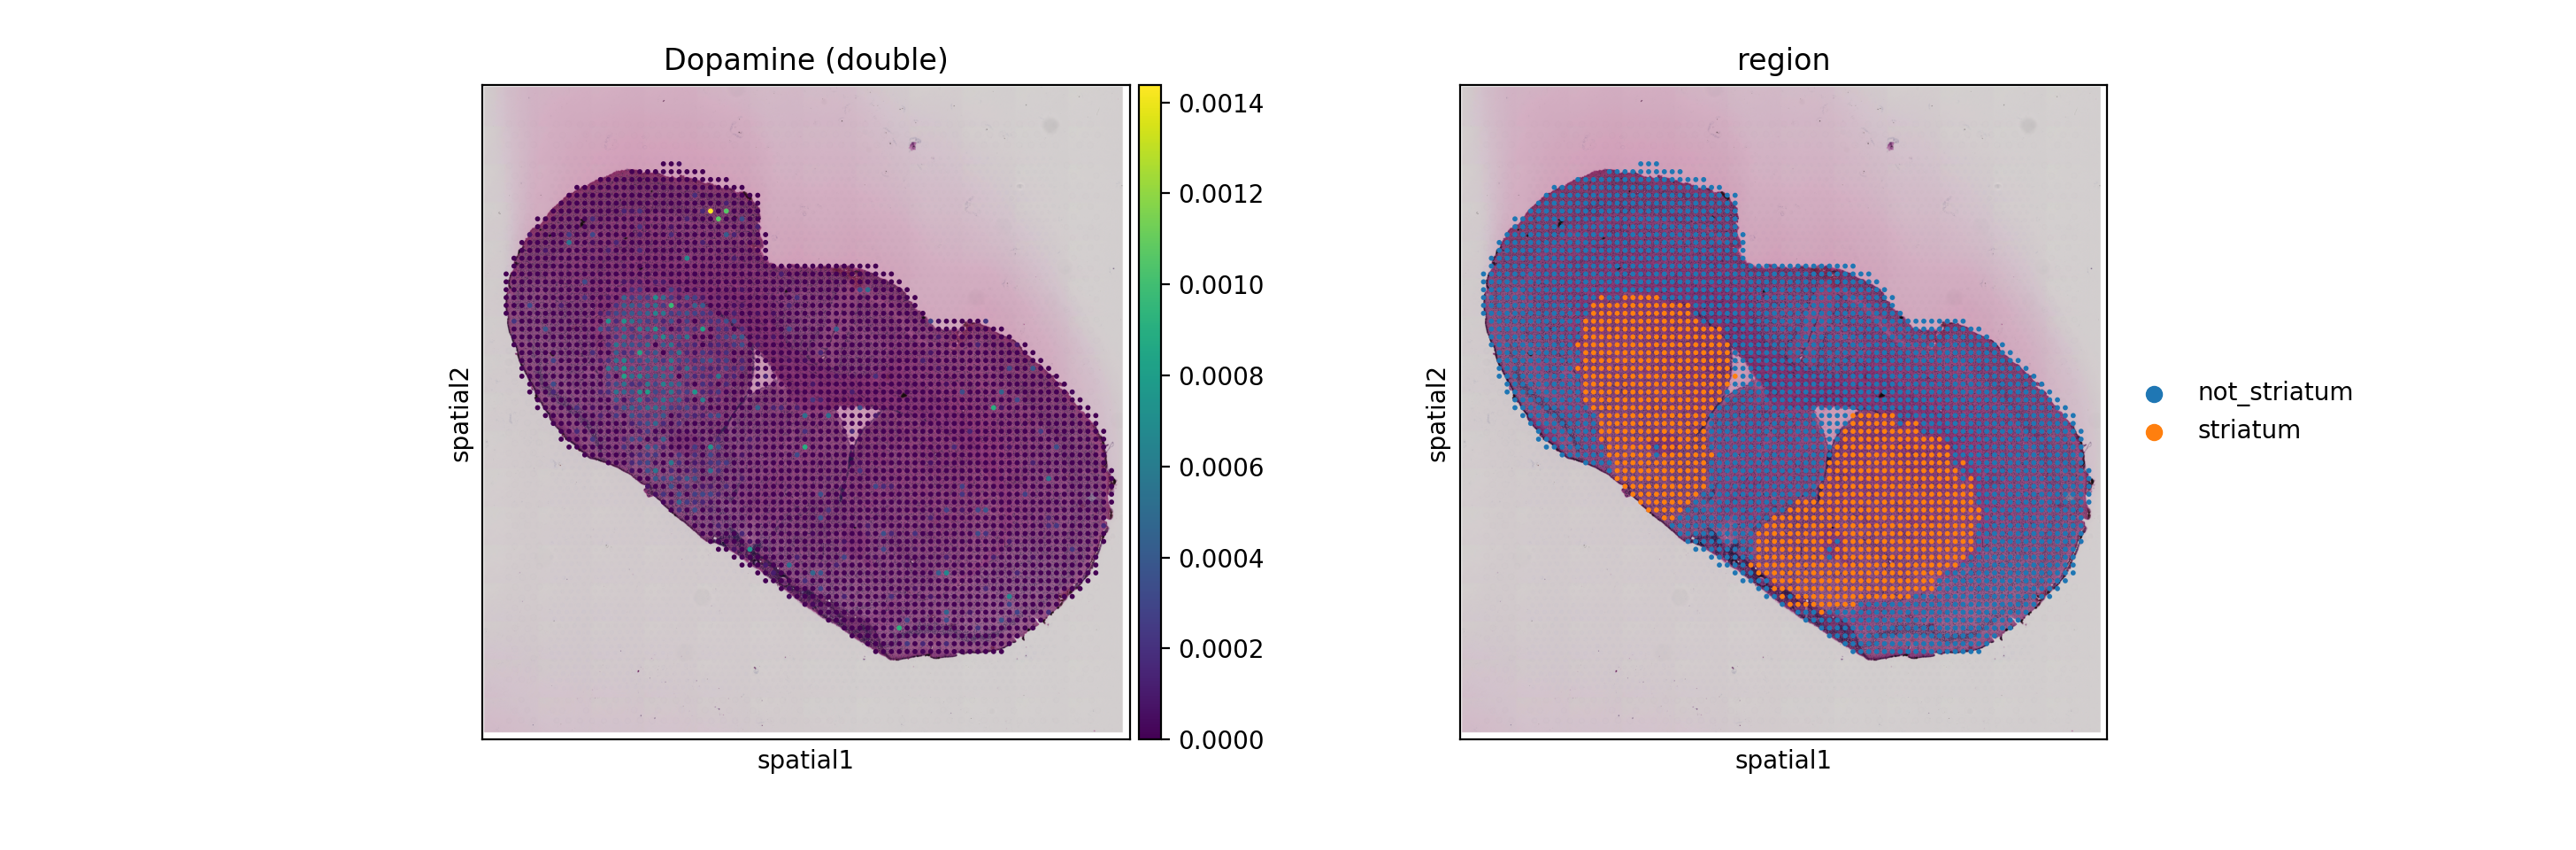

In [39]:
sq.pl.spatial_scatter(msi, color=["Dopamine (double)", "region"])
plt.show()

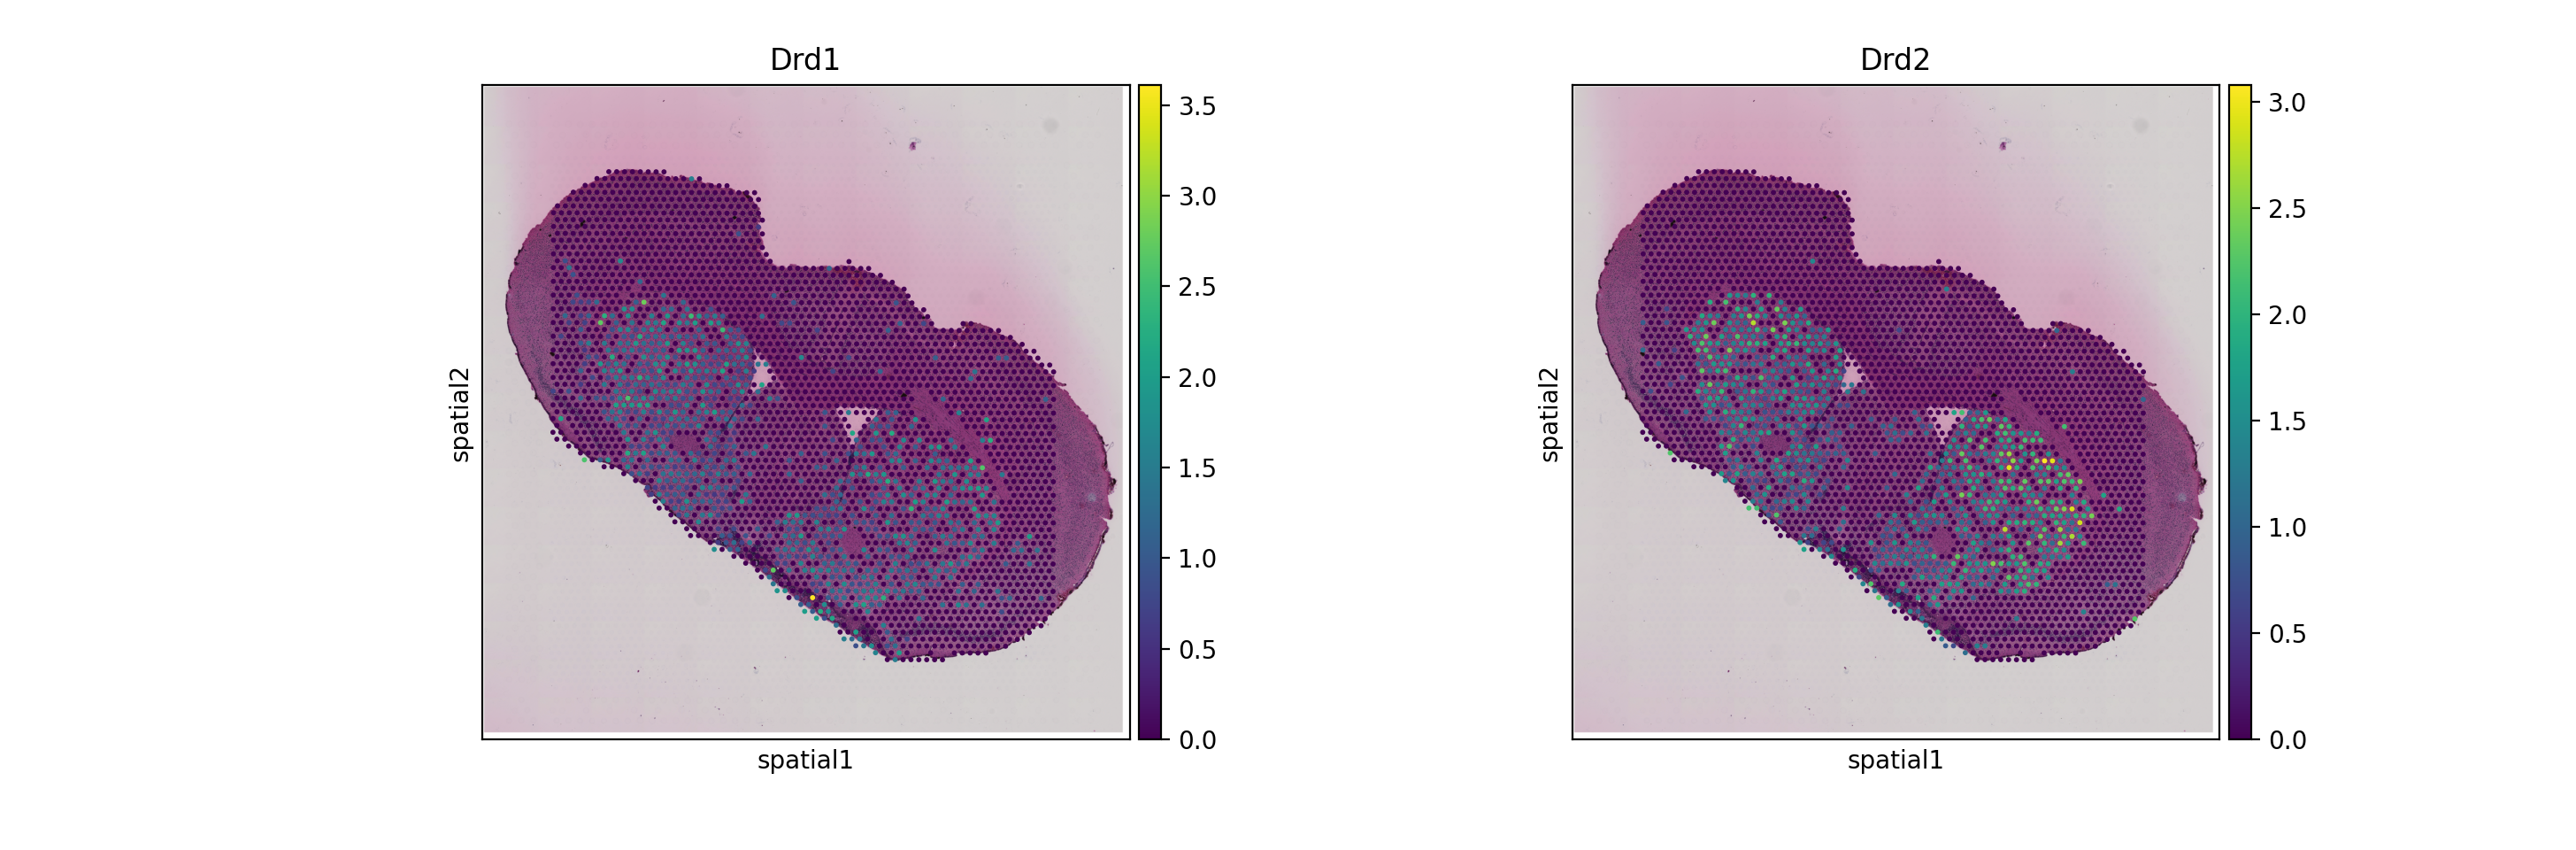

In [42]:
sq.pl.spatial_scatter(rna, color=["Drd1", "Drd2"])
plt.show()

... storing 'slide' as categorical


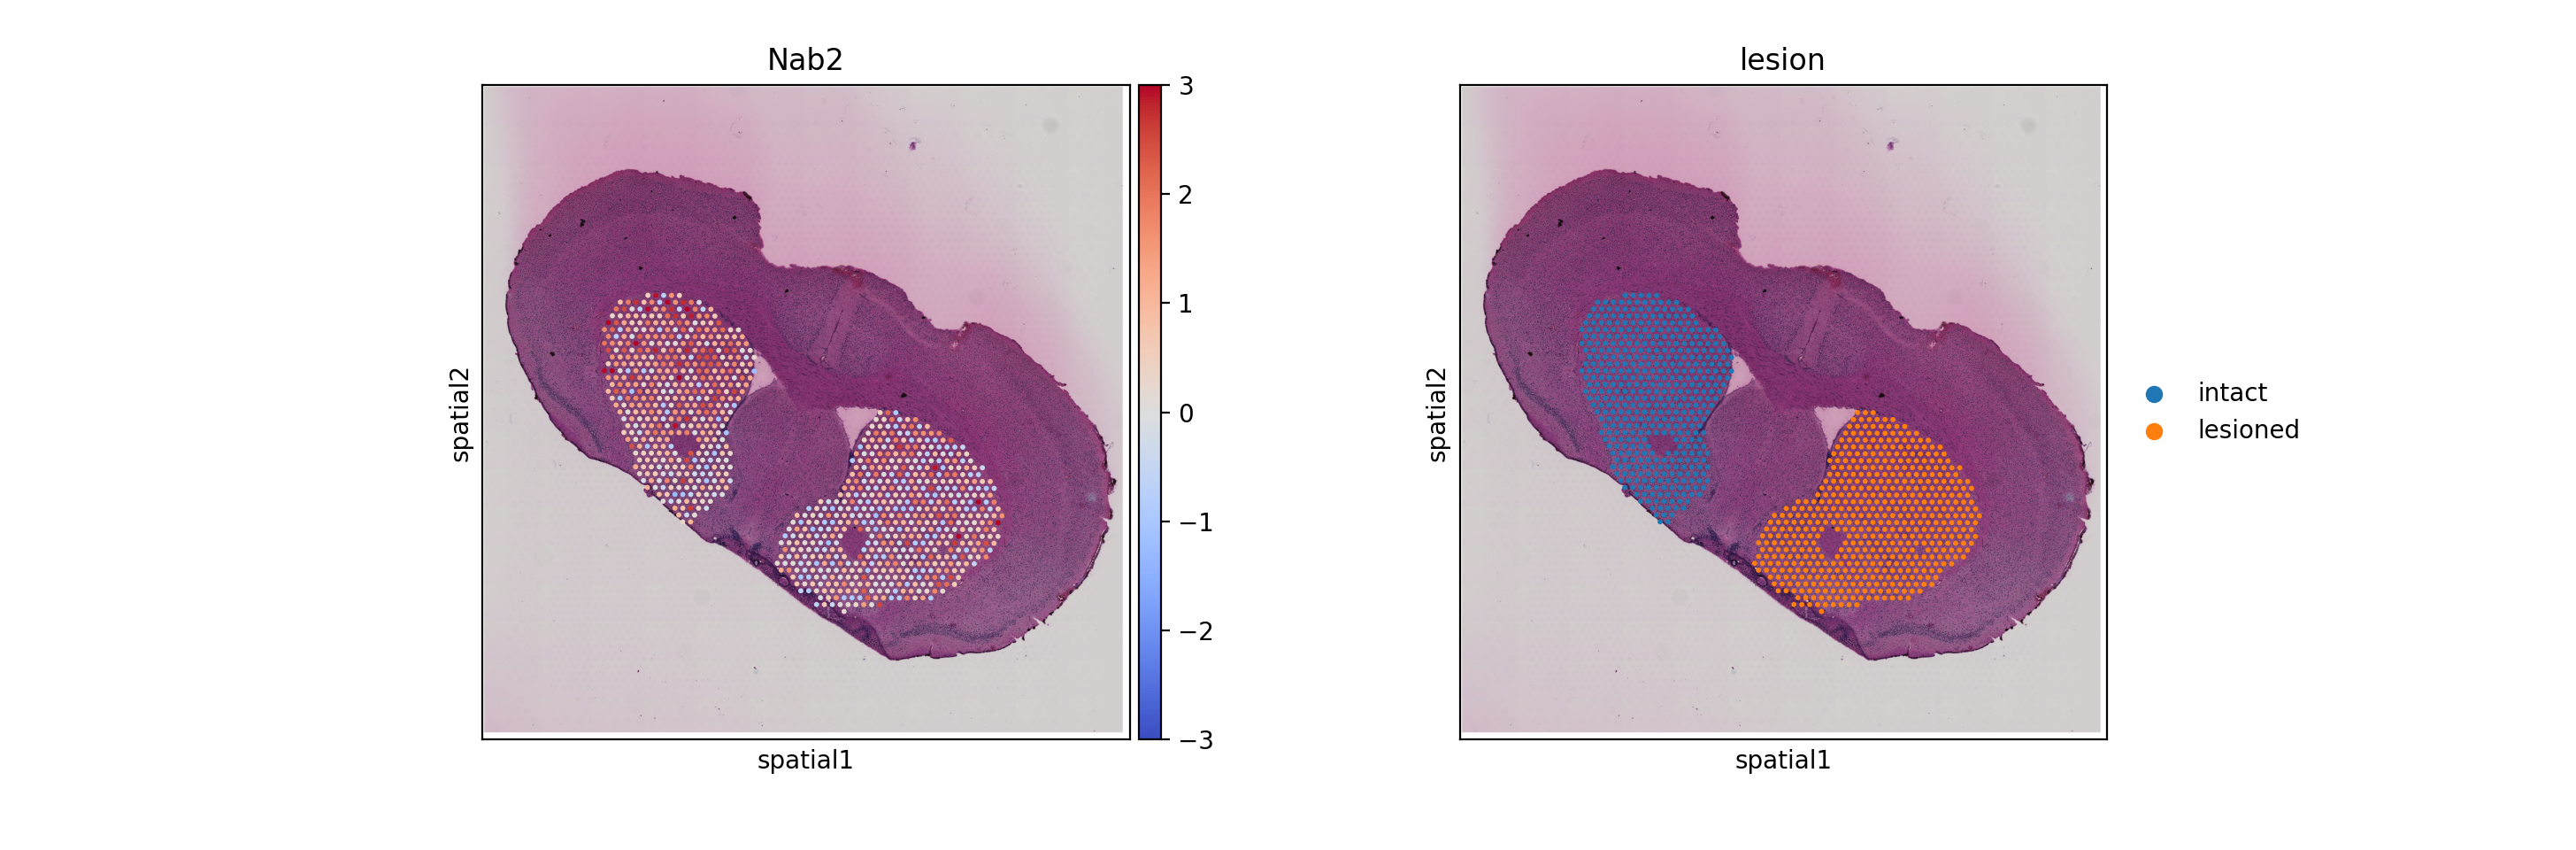

In [43]:
sq.pl.spatial_scatter(tf, color=['Nab2', "lesion"], vmin=-3, vmax=3, cmap='coolwarm')
plt.show()

In [44]:
# obtain ppi network
ppis = op.interactions.OmniPath().get(genesymbols = True)

ppis['mor'] = ppis['is_stimulation'].astype(int) - ppis['is_inhibition'].astype(int)
ppis = ppis[(ppis['mor'] != 0) & (ppis['curation_effort'] >= 1)]

input_pkn = ppis[['source_genesymbol', 'mor', 'target_genesymbol']]
input_pkn.columns = ['source', 'mor', 'target']
input_pkn.head()

source  mor target
0  CALM1   -1  TRPC1
1  CALM3   -1  TRPC1
2  CALM2   -1  TRPC1
3   CAV1    1  TRPC1
4   DRD2    1  TRPC1

In [99]:
comsos_net = pd.read_csv("applications/data/cosmos_network.csv")

In [101]:
# comsos_net = comsos_net.rename(columns={"interaction":'mor'})

source  mor                    target
0      CALM3   -1                     TRPC1
1      CALM1   -1                     TRPC1
2      CALM2   -1                     TRPC1
3       CAV1    1                     TRPC1
4       DRD2    1                     TRPC1
...      ...  ...                       ...
83552  PCBD1    1  Gene10296__PCBD1_reverse
83553   ACE2    1   Gene10301__ACE2_reverse
83554   ACE2    1   Gene10302__ACE2_reverse
83555   ACE2    1   Gene10303__ACE2_reverse
83556  ACOX1    1  Gene10316__ACOX1_reverse

[83557 rows x 3 columns]

In [45]:
input_pkn['source'] = input_pkn['source'].str.title()
input_pkn['target'] = input_pkn['target'].str.title()

In [46]:
# add row to input_pkn
input_pkn.loc[len(input_pkn)] = ['Dopamine', 1, 'Drd2']

In [72]:
input_pkn[input_pkn['target']=='Nab2']

source  mor target
4501   Egr1    1   Nab2


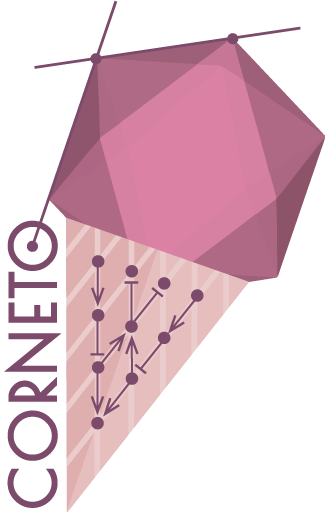

In [73]:
import corneto as cn
cn.info()


In [93]:
# -1, -1, as we dopamine is downregulated absent in lesion and nab2 is downregulated
input_scores = {"Dopamine":-1}
output_scores = {"Nab2":-1}

In [94]:
temp = rna[(rna.obs['region'] == 'striatum') * (rna.obs['lesion'] == 'intact')].copy()

node_weights = pd.DataFrame(temp.X.getnnz(axis=0) / temp.n_obs, index=temp.var_names)
node_weights = node_weights.rename(columns={0: 'props'})
node_weights = node_weights['props'].to_dict()

In [95]:
prior_graph = li.mt.build_prior_network(input_pkn, input_scores, output_scores, verbose=True)

Importing network...
done.
 - Nodes x Edges: (6572, 67121)
 - Provided inputs included in the prior network: 1/1
 - Provided outputs included in the network: 1/1
Performing reachability analysis...
done.
 - Selected inputs: 1/1.
 - Selected outputs: 1/1.
 - Final size of the prior graph: (1831, 8984).


In [96]:
df_res, problem = li.mt.find_causalnet(
    prior_graph,
    input_scores,
    output_scores,
    node_weights,
    # penalize (max_penalty) nodes with counts in less than 0.1 of the cells
    node_cutoff=0.1,
    max_penalty=1,
    # the penaly of those in > 0.1 prop of cells set to:
    min_penalty=0.01,
    edge_penalty=0.01,
    verbose=True,
    max_seconds=60*3,
    solver='scipy'
    )


Total positive/negative scores of the inputs and outputs:
 - (-) input nodes: -1
 - (+) input nodes: 0
 - (-) output nodes: -1
 - (+) output nodes: 0
 - abs total (inputs + outputs): 2
Building CORNETO problem...
Solving with scipy...


                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Nov 16 09:13:49 AM: Your problem has 41465 variables, 31 constraints, and 0 parameters.
(CVXPY) Nov 16 09:13:49 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 16 09:13:49 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 16 09:13:49 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 16 09:13:49 AM: Compiling problem (target solver=SCIPY).
(CVXPY) Nov 16 09:13:49 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffi

Done.
Solution summary:
 - Loss (unfitted inputs/output): [0.]
 - Edge penalty error: 12.0
 - Node penalty error: 0.050033007862115994


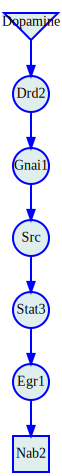

In [97]:
cn.methods.carnival.visualize_network(df_res)

In [ ]:
ints = resource[resource['ligand']=='HMDB0000073'][['ligand', 'receptor']]
# as list of tuples
ints = list(zip(ints['ligand'], ints['receptor']))
# in .replace("Dopamine (double)", "HMDB0000073")
ints = [(i[0].replace("HMDB0000073", "Dopamine (double)"), i[1]) for i in ints]

In [ ]:
mdata = mu.read_h5mu(os.path.join(slide_path, "sma_matched.h5mu"))

In [ ]:
mdata.obsm = mdata.mod['msi'].obsm.copy()

In [ ]:
mdata.uns = mdata.mod['msi'].uns.copy()

In [ ]:
mdata.uns = msi.uns.copy()

In [ ]:
li.ut.spatial_neighbors(mdata, bandwidth=1000, cutoff=0.1, spatial_key="spatial", set_diag=False, standardize=False)

In [ ]:
li.mt.bivar(mdata, 
            interactions=ints,
            x_mod='msi', y_mod='rna',
            function_name='cosine',
            x_use_raw=False, y_use_raw=False,
            mask_negatives=True,
            x_transform=li.ut.zi_minmax,
            y_transform=li.ut.zi_minmax
            )

In [ ]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], color=["Dopamine (double)^Drd2"], size=1.3)

In [ ]:
plt.show()

In [ ]:
sq.pl.spatial_scatter(path, color=["Huntingtons_Disease"], vmax=3, vmin=-3)
plt.show()

In [ ]:
predictors = t_test_results[t_test_results['view']=='tf'].sort_values("p_value").head(20)['predictor'].tolist()

In [ ]:
# sq.pl.spatial_scatter(tfs, color=predictors, cmap='coolwarm', ncols=2, size=1.3)
# plt.show()

In [ ]:
# TODO: change filterby to this format
dopamine_interactions = interactions[interactions.apply(lambda x: (x['target'] in ['Dopamine (double)']) & (x['predictor']=='Pax5'), axis=1)]

In [ ]:
dopamine_interactions.sort_values("importances")

In [ ]:
top_ints = interactions[interactions['target']=='Dopamine (double)'].copy()

In [ ]:
top_ints = top_ints.groupby(['target', 'predictor', 'intra_group', 'view']).agg({'importances': 'mean'}).sort_values("importances", ascending=False, key=abs).head(20).reset_index()

In [ ]:
top_ints

In [ ]:
predictors = top_ints['predictor'].values # [top_ints['view']=='tf']

In [ ]:
interactions[(interactions['predictor'].isin(['Drd1', 'Drd2'])) & (interactions['target']=='Dopamine (double)')].sort_values(["predictor",'intra_group'])

In [ ]:
predictors = predictors[np.isin(predictors, tfs.var.index)]

In [ ]:
sq.pl.spatial_scatter(tfs, color=['region', 'lesion', *predictors], cmap='coolwarm', size=1.3, ncols=2, vmin=-3, vmax=3)
plt.show()

In [ ]:
sq.pl.spatial_scatter(tfs, color=['region' ,'Mef2a'], cmap='coolwarm', size=1.3, ncols=2, vmin=-5, vmax=5)

In [ ]:
sq.pl.spatial_scatter(msi, color=['lesion', 'Dopamine (double)'], cmap='coolwarm', size=1.3, ncols=2)

In [ ]:
plt.show()

In [ ]:
# sq.pl.spatial_scatter(mdata.mod['conn'], color=['Drd1'], size=1.3, ncols=2)
sq.pl.spatial_scatter(rna, color=['Drd1', 'Drd2'], size=1.3, ncols=2)
plt.show()

In [ ]:
dopamine_interactions.sort_values("importances").tail(20)

In [ ]:
(
li.pl.interactions(interactions=dopamine_interactions, view='receptor', top_n=25, ascending=True, key=abs, aggregate_fun='median') + 
# fill red and blue coolwarm pallete
 p9.scale_fill_cmap('RdBu_r', midpoint=0)
)

In [ ]:
### interactions violin plot

In [ ]:
# check gaba target
target_metrics[target_metrics['target']=='3-MT']

In [ ]:
interactions.sort_values('importances', ascending=False, key=abs).head(50)

In [ ]:
view_names = misty.view_names
view_names.remove('intra')

In [ ]:
view_names

In [ ]:
sq.pl.spatial_scatter(msi, color=['Dopamine (double)', '3-MT'])

In [ ]:
li.pl.contributions(target_metrics=target_metrics, view_names=view_names, aggregate_fun='median')

One by One

In [ ]:
slide_path = f"../data/sma/{exp}/{exp}_{slide}/output_data"

HVG

In [ ]:
# sc.pp.highly_variable_genes(rna, flavor='cell_ranger', n_top_genes=500)
# rna = rna[:, rna.var['highly_variable']]

In [ ]:
sc.pp.highly_variable_genes(msi, flavor='cell_ranger', n_top_genes=50)

In [ ]:
# annotated which do not contain peak,
annotated = msi.var['annotated'].astype(str).unique()
annotated = [a for a in annotated if "peak" not in a]

In [ ]:
# highly variable or annotated
msk = (msi.var['highly_variable'].values) + (msi.var.index.isin(annotated))
msi = msi[:, msk].copy()

Test

In [ ]:
# get reference coordinates
reference = mdata.mod["rna"].obsm["spatial"]


In [ ]:
plot, _ = li.ut.query_bandwidth(coordinates=rna.obsm['spatial'], start=0, end=1500, interval_n=20, reference=reference)
plot

In [ ]:
# distances of metabolties to RNA
li.ut.spatial_neighbors(msi, bandwidth=1000, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

In [ ]:
# get reference coordinates
reference = mdata.mod["msi"].obsm["spatial"]

# distances of metabolties to RNA
li.ut.spatial_neighbors(rna, bandwidth=500, cutoff=0.1, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

Funcomics

In [ ]:
dc.run_ulm(rna, net = net, use_raw=False, weight=None)
kegg = li.ut.obsm_to_adata(rna, "ulm_estimate")

In [ ]:
net = dc.get_collectri(organism="mouse")
dc.run_ulm(rna, net = net, use_raw=False)
tfs = li.ut.obsm_to_adata(rna, "ulm_estimate")


Mitsy

In [ ]:
mdata.update_obs()
misty = li.mt.MistyData({"intra": msi, "kegg":kegg, "tf":tfs}, enforce_obs=False, obs=mdata.obs)


In [ ]:
misty(model="linear", verbose=True, bypass_intra=True, maskby='lesion')

In [ ]:
misty.uns['target_metrics'].sort_values("gain_R2", ascending=False).head(10)

In [ ]:
# split df by intra group
misty.uns['target_metrics'].groupby("intra_group").apply(lambda x: x.sort_values("gain_R2", ascending=False).head(10))

In [ ]:
# li.pl.target_metrics(misty, stat='gain_R2', top_n=25, return_fig=True)

In [ ]:
most_explained = misty.uns['target_metrics'].sort_values("gain_R2", ascending=False).head(10)['target'].values

In [ ]:
(
li.pl.interactions(misty, view='tf', top_n=50, figure_size=(8,5), filterby="intra_group", filter_lambda=lambda x: x=="lesioned") +
p9.scale_fill_gradient2(low="blue", mid="white", high="red", midpoint=0)
)

In [ ]:
sq.pl.spatial_scatter(msi, color=['Dopamine (double)', '3-MT', '431.08294'])

In [ ]:
plt.show()

In [ ]:
sq.pl.spatial_scatter(tfs, color=['Irx1', 'Pou5f1', 'Tfap4', 'Znf335'], cmap='coolwarm', size=1.3)

In [ ]:
plt.show()

In [ ]:
metab = '3-MT' # '551.23688'
misty.uns['interactions'][misty.uns['interactions']['target'] == metab].sort_values("importances", key=abs, ascending=False).head(30)

In [ ]:
# Apply Spatial Smoothing with RNA as reference
w2 = li.ut.spatial_neighbors(rna, bandwidth=500, cutoff=0.1, spatial_key="spatial", inplace=False, set_diag=False, standardize=False)
rna.layers['smooth'] = w2 @ rna.X

In [ ]:
rna_smooth = rna[:, 'Pdyn'].layers['smooth'].copy()

In [ ]:
sc.AnnData(msi_smooth[:,'Dopamine (double)'].X * rna_smooth.A.flatten())

In [ ]:
import muon as mu

In [ ]:
mdata = mu.MuData({'rna':rna, 'msi':msi_smooth}, obs=rna.obs, uns=rna.uns)

In [ ]:
mdata

In [ ]:
from scipy.sparse import csr_matrix
w3 = np.zeros((mdata.shape[0], mdata.shape[0]))
w3 = csr_matrix(w3)
w3.setdiag(1)
mdata.obsp['spatial_connectivities'] = w3

In [ ]:
mdata

In [ ]:
li.mt.bivar(mdata, function_name='product', x_mod='rna', y_mod='msi', x_layer='smooth', x_use_raw=False, y_use_raw=False, verbose=True, interactions = [('Pdyn', 'Dopamine (double)')])

In [ ]:
mdata.mod['local_scores'].obsm = rna.obsm

In [ ]:
sq.pl.spatial_scatter(mdata.mod['local_scores'], color=['Pdyn^Dopamine (double)', 'lesion'])

In [ ]:
plt.show()

In [ ]:
mdata.mod['local_scores'].obs

Metalinks

In [ ]:
from applications._estimate_metalinks import estimate_metalinks

In [ ]:
# estimate metabolites
metalinks = estimate_metalinks(rna, resource=resource, met_net=met_net, consider_transport=True, min_n=3)

In [ ]:
metalinks.mod['metabolite'].var

In [ ]:
act = pd.DataFrame([metalinks.mod['metabolite'].X.mean(axis=0)], columns= metalinks.mod['metabolite'].var.index)

In [ ]:
obs = pd.DataFrame([rna.X.mean(axis=0).A.flatten()], columns=rna.var.index)

In [ ]:
met_net.rename({"Symbol": "target", "HMDB":"source"}, axis=1, inplace=True)

In [ ]:
met_net = met_net[met_net['source']=="HMDB0000073"]
met_net = met_net[met_net['target'].isin(rna.var.index)]

In [ ]:
met_net